In [1]:
from sklearn.model_selection import train_test_split
from PIL import Image, ImageDraw, ImageFont

from torch.utils.data import DataLoader
from torchvision import transforms

import config
from dataset import OCRDataset
import utils

In [2]:
selected_annotation_list, index_to_utf16 = utils.prepare_selected_annotation_from_dataset_indexes([6, 12])
train_annotation_list, validation_annotation_list = train_test_split(selected_annotation_list,
                                                                     test_size=0.2,
                                                                     random_state=config.RANDOM_SEED)

In [3]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = OCRDataset(train_annotation_list, transform=tf)
validation_dataset = OCRDataset(validation_annotation_list, transform=tf)

batchsize = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batchsize, shuffle=False)

In [4]:
def show_result(image, bboxes):
    fontpath = '../../font/HanaMinA.ttf'
    font = ImageFont.truetype(fontpath, 14)
    
    toPIL = transforms.ToPILImage()
    image_PIL = toPIL(image*0.5 + 0.5)
    draw = ImageDraw.Draw(image_PIL)
    for char_index, bboxes_per_class in enumerate(bboxes):
        confience, center_x, center_y, width, height = bboxes_per_class
        min_x = center_x - 0.5*width
        min_y = center_y - 0.5*height
        max_x = center_x + 0.5*width
        max_y = center_y + 0.5*height
        utf16 = index_to_utf16[char_index]
        mess = (('\\u' + utf16[2:]).encode()).decode('unicode-escape')
        for minx, miny, maxx, maxy in zip(min_x, min_y, max_x, max_y):
            draw.rectangle((minx, miny, maxx, maxy), fill=None, outline=(0,255,0))
            # draw.rectangle((minx, miny, maxx, maxy), fill=None, outline=(255,0,0))
            draw.text((maxx, miny), mess, font=font, fill=(0,0,255))
    return image_PIL

In [7]:
train_images, train_labels = iter(train_loader).next()
validation_images, validation_labels = iter(validation_loader).next()

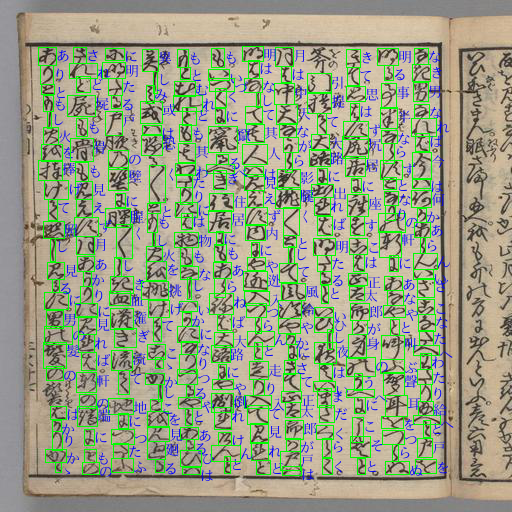

In [24]:
index = 16
image = train_images[index]
bboxes = train_dataset.label2bboxes(train_labels[index])
show_result(image, bboxes)

In [ ]:
def show_result_hyper(image, bboxes):
    image_np = np.zeros((image.size(1), image.size(2), 3))
    image_np[:,:,:] = np.transpose(image.numpy(), [1, 2, 0])*0.5 + 0.5
    for char_index, bboxes_per_class in enumerate(bboxes):
        confience, center_x, center_y, width, height = bboxes_per_class
        min_x = center_x - 0.5*width
        min_y = center_y - 0.5*height
        max_x = center_x + 0.5*width
        max_y = center_y + 0.5*height
        mess = index_to_utf16[char_index]
        for minx, miny, maxx, maxy in zip(min_x, min_y, max_x, max_y):
            image_np = cv2.rectangle(image_np,
                                     (minx, miny), (maxx, maxy), (1, 0, 0), 2)
            image_np = cv2.putText(image_np, mess, (minx, miny), 0, 0.2, (0, 1, 0), 1)
    return image_np